# **Biblioteki**

In [3]:
# !pip install pingouin

In [4]:
# !pip install shap

In [5]:
!pip install interpret


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import shap
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret.glassbox import ClassificationTree
from sklearn.model_selection import train_test_split

# **Przygotowanie danych**

Dane pochodzą z ze strony kaggle, link:

https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

Dotyczą one cukrzycy wśród kobiet powyżej 21 roku życia pochodzących z Indii:

Pregnancies - liczba ciąż,

Glucose - stężenie glukozy w osoczu po 2 godzinach (doustny test stężenia glukozy),

BloodPressure - rozkurczowe ciśnienie krwi (mmHg),

SkinThickness - grubość fałdu skórnego (mm),

Insulin - stężenie insuliny w surowicy po 2 godzinach (mu U/ml)

BMI - waga w kg/(wzrost w m)^2

DiabetesPedigreeFunction - współczynnik wyliczany na podstawie wieku pacjentki i historii przypadków cukrzycy w rodzinie,

Age - wiek (lata),

Outcome - 0 - osoba zdrowa, 1 - osoba chora na cukrzycę.


Zbiór danych:



In [7]:
df = pd.read_csv("diabetes.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [9]:
# Brakujące dane
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Dane są kompletne.

**Ile mamy przypadków zdrowych, a ile chorych pacjentek w zbiorze?** - analiza przypadków - wizualizacja

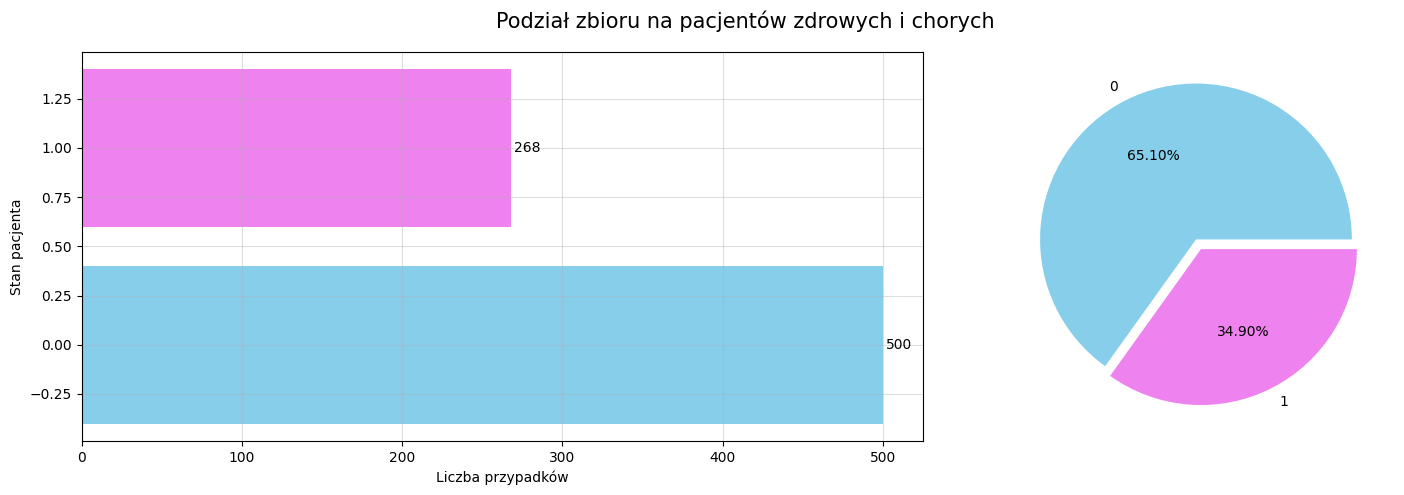

In [10]:
status = df['Outcome'].value_counts().sort_index()
colors = ['skyblue','violet']

figure, axes = plt.subplots(1,2, figsize=(15,5), gridspec_kw={'width_ratios':[1.5,1]})
axes[0].barh(y=status.index, width=status.values, color=colors)
axes[0].set_xlabel('Liczba przypadków')
axes[0].set_ylabel('Stan pacjenta')

for index, values in enumerate(status):
    axes[0].text(values+2, index, str(values), va='center')

axes[0].grid(alpha=0.4)
axes[1].pie(status.values, labels=status.index, colors=colors, explode=[0.05,0.02], autopct='%.2f%%')
figure.suptitle('Podział zbioru na pacjentów zdrowych i chorych', fontsize=15)
plt.tight_layout()
plt.show()

**Wykresy pairplot dla zbioru danych:**

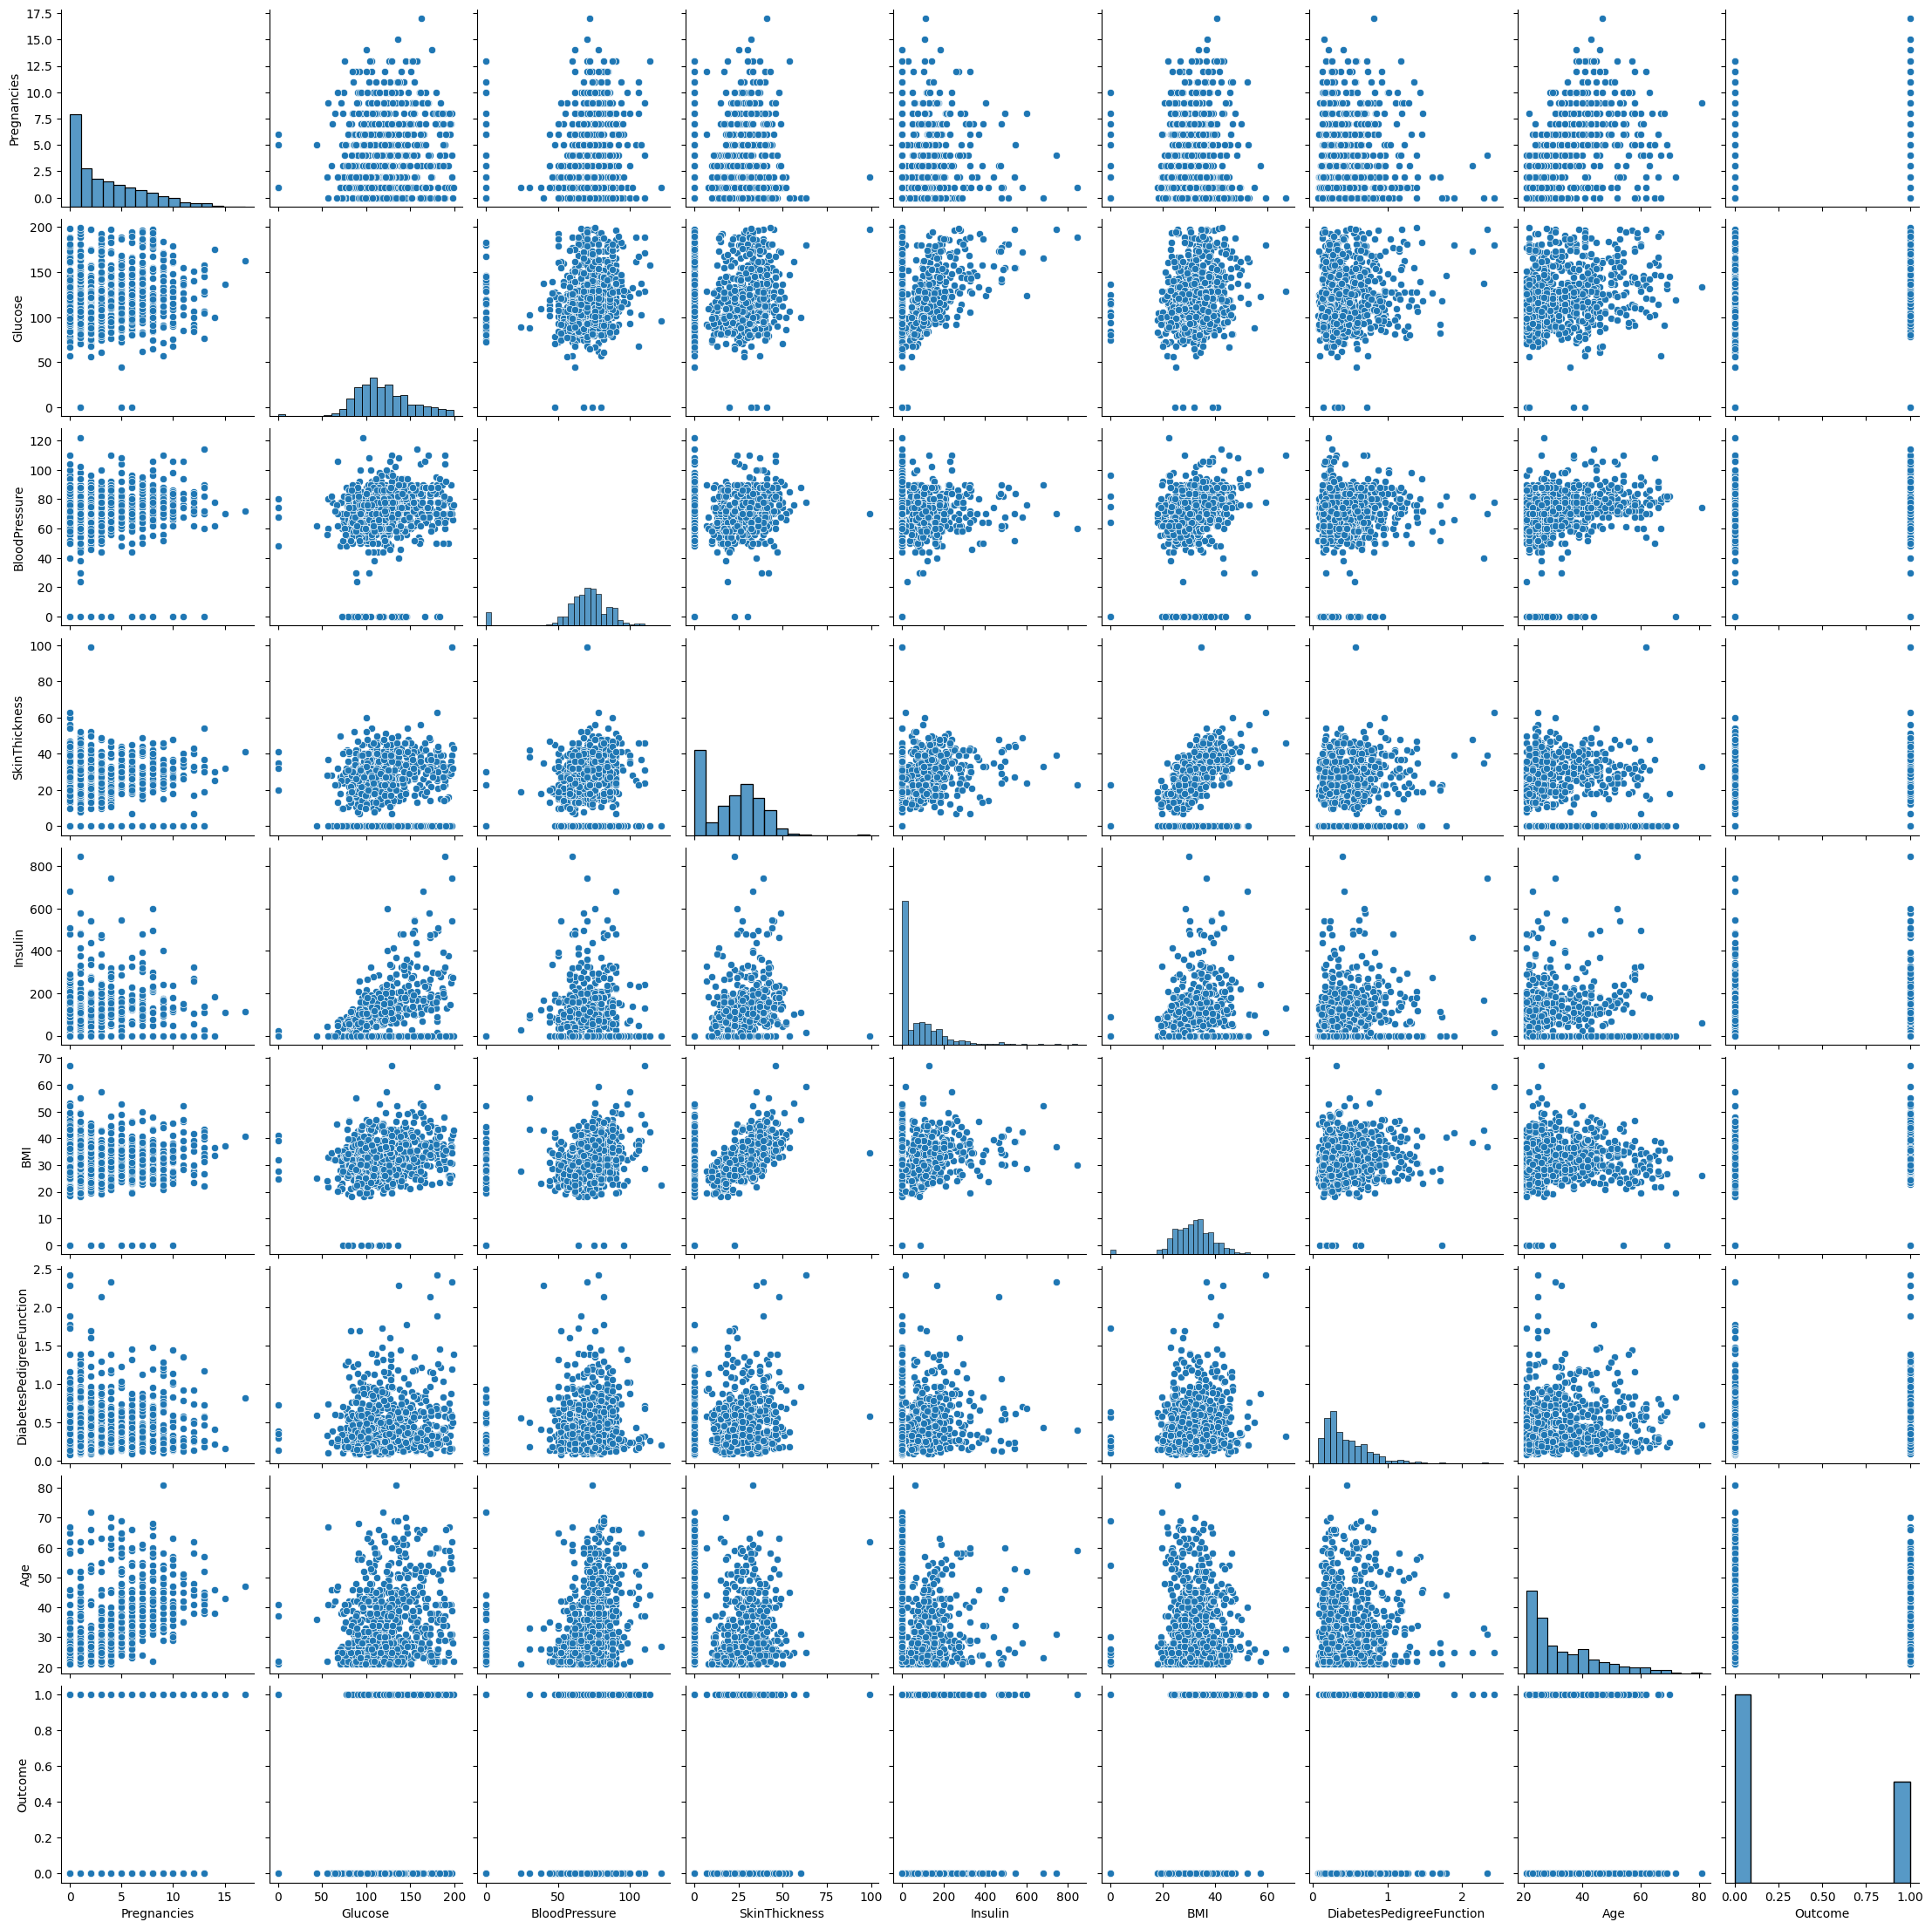

In [11]:
sns.pairplot(df)

Czy na podstawie wykresów można podejrzewać, że istnieje silna korelacja pomiędzy zmiennymi?

**ODP:**

# **Wybór cech**

## **SHAP**

**SHAP** (SHapley Additive exPlanations) jest to podejście oparte na teorii gier, mające na celu wyjaśnienie wyników dowolnego modelu uczenia maszynowego.

Analizowany zbiór danych ma niewiele cech dlatego można przeprowadzić na nim analizę SHAP - analiza ta pozwala określić jak zmiana wartości cech wpływa na wyjście modelu. Do przedstawienia działania algorytmu wykorzystany zostanie las losowy.




https://shap.readthedocs.io/en/latest/index.html

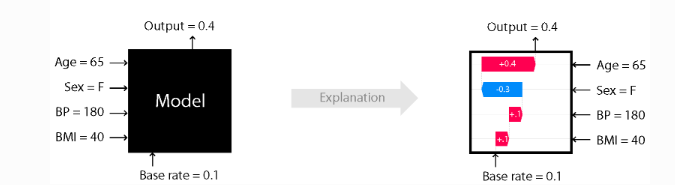
  


**Na tym etapie nie standaryzujemy danych - ułatwi to zrozumienie modelu.**

In [30]:
# Podział danych na cechy (X) i etykietę (y)
X = df.drop(['Outcome'], axis=1)
y = df['Outcome']

# Podział na zestaw treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Wczytanie estymatora lasu losowego
rf_classifier = RandomForestClassifier(random_state=42).fit(X_train, y_train)

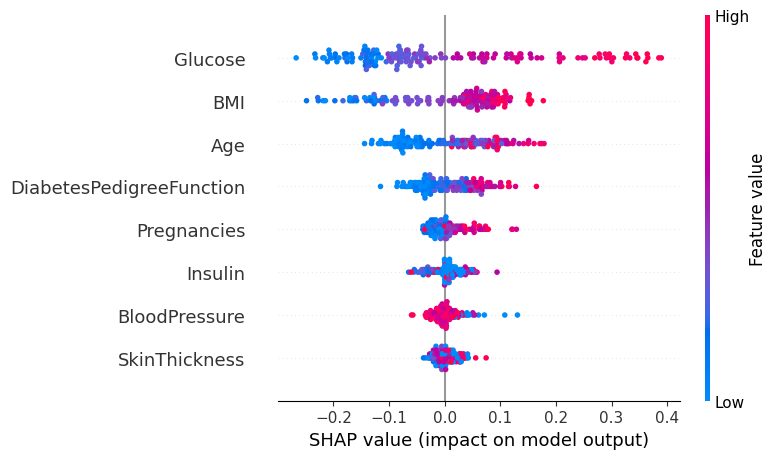

In [31]:
# wyznaczcenie wartości SHAP
explainer = shap.TreeExplainer(rf_classifier)
shap_values = explainer.shap_values(X_test)

# Narysowanie wykresu
shap.summary_plot(shap_values[1], X_test)


**Co można odczytać z tego wykresu ?**

Każdy punkt jest jedną, konkretną wartością ze zbioru danych:

1) położenie punktu:

* wysokość punktu (położenie na osi y) oznacza, z której kolumny jest ta wartość (jaką cechę reprezentuje),

* wartość SHAP dla punktu (położenie na osi x), jak wartość tego punktu wpływa na wyjście,

2) kolor punktu:

* różowy - wysoka wartość badanej cechy,

* niebieski - niska wartość badanej cechy,

* fioletowy - wartość bliska średniej,

3) kolejność cech:

* im wyżej jest dana cecha tym ma ona większe znaczenie dla predykcji modelu.

**Przykładowa interpretacja:**

Najbardziej istotną cechą jest Glucose, a najmniej istotną jest SkinThickness.

Wartość stężenia glukozy ma najwyższy wpływ na predykcję modelu - wysoka wartość stężenie glukozy (różowe punkty) - znacząco wpływa na klasyfikację pacjentki jako chorej na cukrzycę, niska wartość stężenia glukozy (niebieskie punkty) - ma duży wpływ na klasyfikację pacjentki jako zdrowej.  

**Proszę zinterpretować:**

Pregnancies, BMI, DiabetesPedigreeFunction oraz Age.

**ODP:**

**Żeby zrozumieć, jak pojedyncza cecha wpływa na wyniki modelu, możemy wykreślić wartość SHAP dla tej cechy w funkcji wartości tej cechy:**

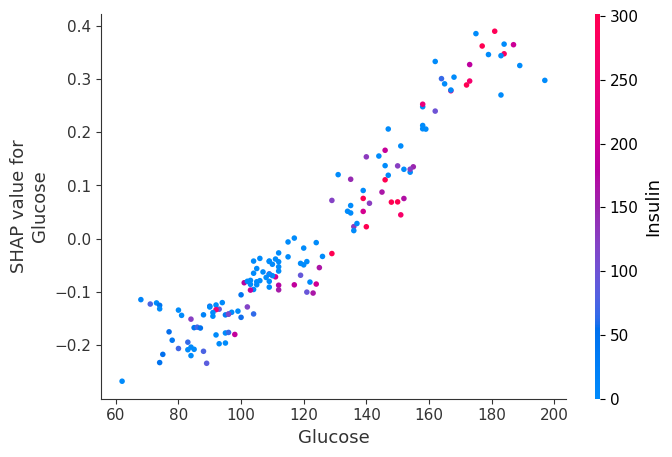

In [32]:
shap.dependence_plot("Glucose", shap_values[1], X_test)

**Interpretacja:**

* kolor punktów: różowy - wysoka wartość stężenia insuliny, niebieski - niska wartość stężenia insuliny,

* rozkład punktów przypomina funkcję rosnącą - oznacz to, że im wyższa wartość stężenia glukozy tym, wyższa jest szansa na klasyfikację pacjentki jako chorej,

*  rozkład punktów sugeruje, że zachodzi interakcja pomiędzy stężeniem glukozy a stężeniem insuliny, która ma wpływ na model:

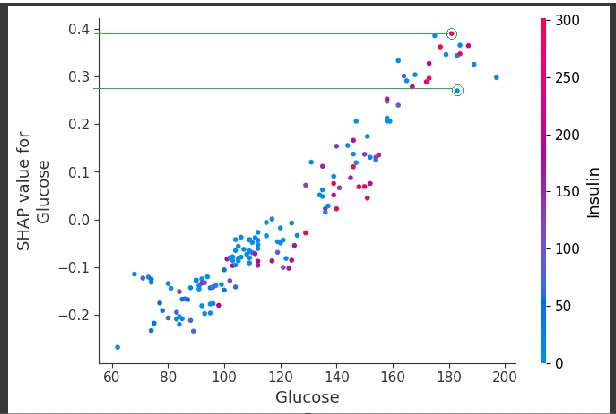

Przy podobnym stężeniu glukozy mamy inną wartość SHAP, niskie stężenie insuliny przy wysokim stężeniu glukozy zmniejsza ryzyko wystąpienia cukrzycy. Gdy oba parametry mają wysoką wartość ryzyko cukrzycy rośnie.

**Zadanie:**

Proszę narysować i zinterpretować wykres dla wybranej cechy (Pregnancies, BMI, DiabetesPedigreeFunction lub Age).



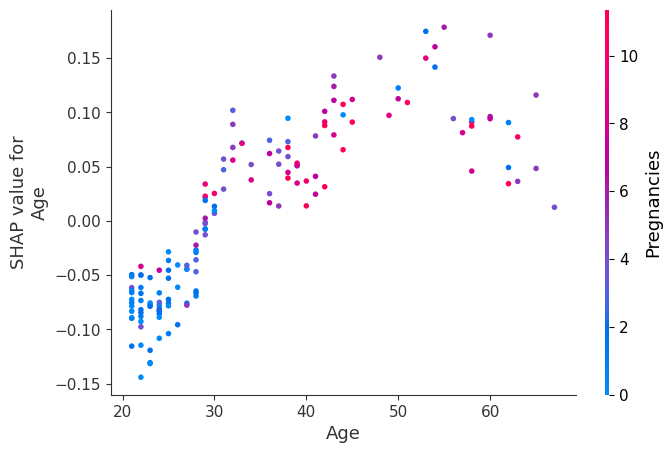

In [36]:
# Rozwiązanie
shap.dependence_plot("Age", shap_values[1], X_test)

Wzrost wieku i wzrost ilości ciąży wpływa na wzrost prawdopodobieństwa choroby.

**SHAP daje nam również możliwość narysowania interaktywnego wykresu, który wyjaśnia cały zbiór danych.**

Zmieniając wartości na osiach, możemy zobaczyć jak dane wartości cech wpływają na predykcję.

In [16]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test)

##**RFE i feature_importances_**

**Klasyfikacja z wykorzystaniem wszystkich cech:**

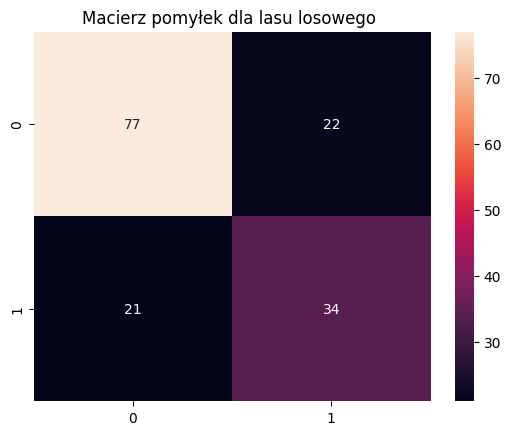

Raport klasyfikacji dla lasu losowego 
              precision    recall  f1-score   support

           0       0.79      0.78      0.78        99
           1       0.61      0.62      0.61        55

    accuracy                           0.72       154
   macro avg       0.70      0.70      0.70       154
weighted avg       0.72      0.72      0.72       154



In [17]:
# Standaryzacja cech
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Wytrenowanie klasyfikatora
rf_classifier_full = RandomForestClassifier(random_state=42)
rf_classifier_full.fit(X_train_scaled, y_train)

# Prognozy i metryki
rf_predictions_full = rf_classifier_full.predict(X_test_scaled)
rf_confusion_matrix_full = confusion_matrix(y_test, rf_predictions_full)
rf_classification_report_full = classification_report(y_test, rf_predictions_full)

# Wizualizacja macierzy pomyłek
sns.heatmap(rf_confusion_matrix_full, annot=True, fmt="d")
plt.title('Macierz pomyłek dla lasu losowego ')
plt.show()

# Wyświetlenie raportu klasyfikacji
print("Raport klasyfikacji dla lasu losowego ")
print(rf_classification_report_full)


Analizując wyniki można stwierdzić, że jakość klasyfikacji nie jest wysoka. Wykorzystajmy funkcję feature_importances_ do selekcji cech.


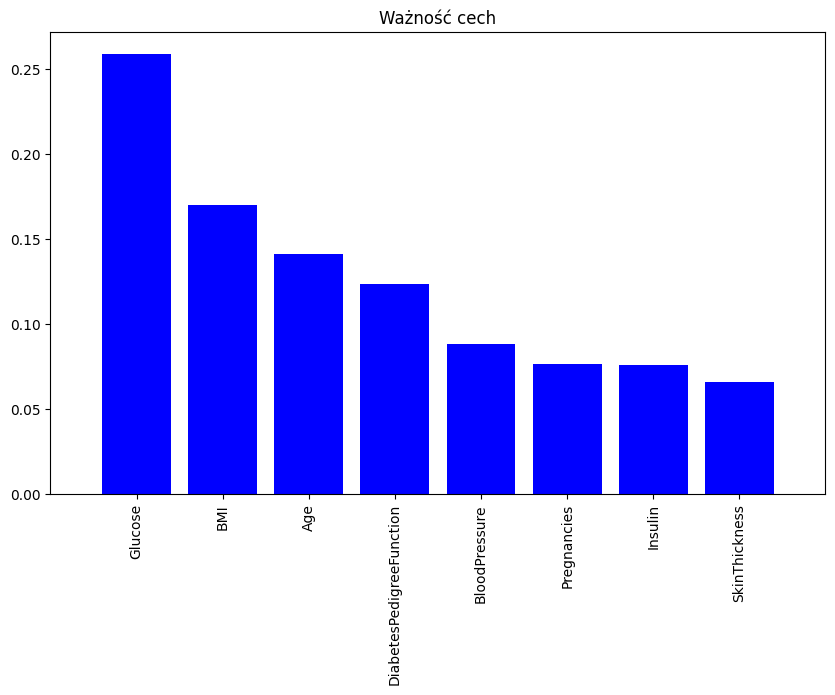

In [18]:
importances = rf_classifier.feature_importances_

# Wizualizacja ważności cech
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Ważność cech")
plt.bar(range(X_train_scaled.shape[1]), importances[indices], color='b', align='center')
plt.xticks(range(X_train_scaled.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X_train_scaled.shape[1]])
plt.show()

Czy ranking istotności cech jest taki sam według wielkości SHAP i funkcji feature_importances_ ?

Jeśli nie to, od którego miejsca zachodzi różnica ? Czy ta różnica może być istotna ?

**ODP:**

**Proszę przeprowadzić klasyfikację z wykorzystaniem 4 najistotniejszych cech.**

Czy jakośc klasyfikacji uległa poprawie ?

In [39]:
# Rozwiązanie
cechy = ['Glucose', 'BMI', 'Age', 'DiabetesPedigreeFunction']

X_train, X_test, y_train, y_test = train_test_split(X[cechy], y, test_size=0.2, random_state=42)
X_train.head()

,Glucose,BMI,Age,DiabetesPedigreeFunction
60,84,0.0,21,0.304
618,112,28.2,50,1.282
346,139,28.7,22,0.654
294,161,21.9,65,0.254
231,134,46.2,46,0.238


**ODP:**


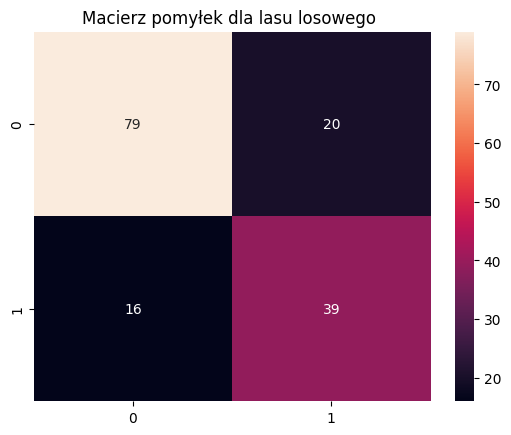

Raport klasyfikacji dla lasu losowego 
              precision    recall  f1-score   support

           0       0.83      0.80      0.81        99
           1       0.66      0.71      0.68        55

    accuracy                           0.77       154
   macro avg       0.75      0.75      0.75       154
weighted avg       0.77      0.77      0.77       154



In [40]:
# Standaryzacja cech
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Wytrenowanie klasyfikatora
rf_classifier_full = RandomForestClassifier(random_state=42)
rf_classifier_full.fit(X_train_scaled, y_train)

# Prognozy i metryki
rf_predictions_full = rf_classifier_full.predict(X_test_scaled)
rf_confusion_matrix_full = confusion_matrix(y_test, rf_predictions_full)
rf_classification_report_full = classification_report(y_test, rf_predictions_full)

# Wizualizacja macierzy pomyłek
sns.heatmap(rf_confusion_matrix_full, annot=True, fmt="d")
plt.title('Macierz pomyłek dla lasu losowego ')
plt.show()

# Wyświetlenie raportu klasyfikacji
print("Raport klasyfikacji dla lasu losowego ")
print(rf_classification_report_full)

**Wykorzystanie metody RFE do ustalenia istotności cech**

Poszukujemy 4 najistotniejsze cechy:

In [20]:
# RFE - estymator las losowy
X = df.drop(['Outcome'], axis=1)
# skalowanie danych
scaler = StandardScaler()
X_scaled= scaler.fit_transform(X)

# RFE
rf_classifier = RandomForestClassifier(random_state=42)
rfe = RFE(estimator = rf_classifier, n_features_to_select = 4)  # n_features_to_select = 4 najlepsze cechy
rfe.fit(X_scaled,y)
rfe.ranking_

array([3, 1, 2, 5, 4, 1, 1, 1])

In [21]:
idx = []
for i, num in enumerate(rfe.ranking_):
  if num == 1:
    idx.append(i)
  else:
    continue

df_features = df.iloc[:,idx]
df_features

,Glucose,BMI,DiabetesPedigreeFunction,Age
0,148,33.6,0.627,50
1,85,26.6,0.351,31
2,183,23.3,0.672,32
3,89,28.1,0.167,21
4,137,43.1,2.288,33
...,...,...,...,...
763,101,32.9,0.171,63
764,122,36.8,0.340,27
765,121,26.2,0.245,30
766,126,30.1,0.349,47


**Czy te same 4 cechy zostały uznane za najistotniejsze?**

**ODP:**

**Wykorzystanie algorytmu RFE z walidacją krzyżową do ustalenia istotności cech**

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV


cv - określa podział zbioru,

min_features_to_select -  minimalna liczba cech,

step - liczba obiektów do usunięcia w każdej iteracji.




In [22]:
rfecv = RFECV(estimator = rf_classifier,  cv = 5, min_features_to_select= 4, step = 3)

rfecv.fit(X_scaled,y)
rfecv.ranking_


array([2, 1, 1, 2, 2, 1, 1, 1])

In [23]:
idx = []
for i, num in enumerate(rfecv.ranking_):
  if num == 1:
    idx.append(i)
  else:
    continue

df_features = df.iloc[:,idx]
df_features

,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age
0,148,72,33.6,0.627,50
1,85,66,26.6,0.351,31
2,183,64,23.3,0.672,32
3,89,66,28.1,0.167,21
4,137,40,43.1,2.288,33
...,...,...,...,...,...
763,101,76,32.9,0.171,63
764,122,70,36.8,0.340,27
765,121,72,26.2,0.245,30
766,126,60,30.1,0.349,47


Dodanie walidacji krzyżowej wskazało 5 najistotniejszych cech.

**Klasyfikacja z wykorzystaniem 5 najistotniejszych cech:**

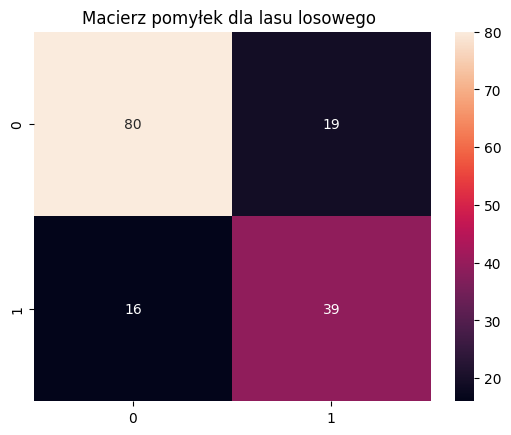

Raport klasyfikacji dla lasu losowego :
              precision    recall  f1-score   support

           0       0.83      0.81      0.82        99
           1       0.67      0.71      0.69        55

    accuracy                           0.77       154
   macro avg       0.75      0.76      0.76       154
weighted avg       0.78      0.77      0.77       154



In [41]:
X = df_features
y = df['Outcome']

# Podział na zestaw treningowy i testowy

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standaryzacja cech
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Wytrenowanie klasyfikatora
rf_classifier_full = RandomForestClassifier(random_state=42)
rf_classifier_full.fit(X_train_scaled, y_train)

# Prognozy i metryki
rf_predictions_full = rf_classifier_full.predict(X_test_scaled)
rf_confusion_matrix_full = confusion_matrix(y_test, rf_predictions_full)
rf_classification_report_full = classification_report(y_test, rf_predictions_full)

# Wizualizacja macierzy pomyłek
sns.heatmap(rf_confusion_matrix_full, annot=True, fmt="d")
plt.title('Macierz pomyłek dla lasu losowego ')
plt.show()

# Wyświetlenie raportu klasyfikacji
print("Raport klasyfikacji dla lasu losowego :")
print(rf_classification_report_full)

**Czy wyniki uległy poprawie? Czy zwiększenie zbioru do 5 cech ma sens?**

**ODP:**

**Poprawa hiperparametrów lasu:**

Do poprawienia hiperparametrów estymatora wykorzystany zostanie GridSearchCV, który wykorzystuje między innymi przestrzeń hiperparametrów i walidację krzyżową do sprawdzenia wybranych kombinacji hiperparametrów estymatora. Jest to szybka metoda, która jednocześnie sprawdza powtarzalność wyników poprzez walidację krzyżową.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html


In [42]:
# wybrane wartości parametrów do sprawdzenia:

kryterium = ['gini', 'entropy', 'log_loss']
n_estimators = [100, 50, 150]
max_depth = [None, 10, 5]
# metryki, na podstawie, których dokonamy wyboru:
scores = ['accuracy','precision_macro', 'recall_macro']

parameters = {'n_estimators' : n_estimators , 'max_depth':max_depth, 'criterion': kryterium, 'random_state': [42]}

In [43]:
X = df[['Age', 'BMI', 'Glucose', 'DiabetesPedigreeFunction']]
y = df['Outcome']


x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, random_state = 42)

# skalowanie danych
scaler = StandardScaler()
X_scaled= scaler.fit_transform(X)
x_train_1_scaled = scaler.fit_transform(x_train_1)

rfc_1 = RandomForestClassifier(random_state = 42)
rfc_g1 = GridSearchCV(rfc_1, parameters)
rfc_g1.fit(X_scaled, y)

grid_search_1 = GridSearchCV(estimator = RandomForestClassifier(),
             param_grid=parameters, scoring =  scores, refit = False)

grid_search_1.fit(x_train_1_scaled, y_train_1)

KeyboardInterrupt: 

In [27]:
# utworzenie i posortowanie tabeli wyników na podstawie średniej dokładności

wyniki_las_1 = pd.DataFrame(grid_search_1.cv_results_["params"])

wyniki_las_1['srednie ac'] = grid_search_1.cv_results_['mean_test_accuracy']
wyniki_las_1['srednia prec'] = grid_search_1.cv_results_['mean_test_precision_macro']
wyniki_las_1['sredni re'] = grid_search_1.cv_results_['mean_test_recall_macro']

wyniki_las_1.sort_values(by=['srednie ac'], ascending= False)

,criterion,max_depth,n_estimators,random_state,srednie ac,srednia prec,sredni re
19,log_loss,NaN,50,42,0.770399,0.749572,0.733957
10,entropy,NaN,50,42,0.770399,0.749572,0.733957
26,log_loss,5.0,150,42,0.767120,0.746871,0.722821
17,entropy,5.0,150,42,0.767120,0.746871,0.722821
8,gini,5.0,150,42,0.767120,0.746831,0.725003
6,gini,5.0,100,42,0.763868,0.742190,0.723705
0,gini,NaN,100,42,0.762268,0.740237,0.726828
24,log_loss,5.0,100,42,0.762242,0.741753,0.716840
15,entropy,5.0,100,42,0.762242,0.741753,0.716840
7,gini,5.0,50,42,0.760616,0.738860,0.717836


**Na podstawie otrzymanych wyników przyjmujemy następujące parametry:**

n_estimators= 50, criterion='log_loss', max_depth = NaN

**Klasyfikacja z wykorzystaniem 4 najistotniejszych cech i najlepszych parametrów dla estymatora:**

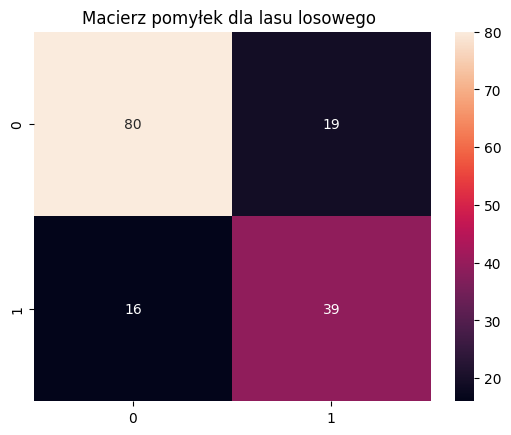

Raport klasyfikacji dla lasu losowego 
              precision    recall  f1-score   support

           0       0.83      0.81      0.82        99
           1       0.67      0.71      0.69        55

    accuracy                           0.77       154
   macro avg       0.75      0.76      0.76       154
weighted avg       0.78      0.77      0.77       154



In [28]:
X = df[['Age', 'BMI', 'Glucose', 'DiabetesPedigreeFunction']]
y = df['Outcome']

# Podział na zestaw treningowy i testowy

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standaryzacja cech
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Wytrenowanie klasyfikatora
rf_classifier_full = RandomForestClassifier(n_estimators= 50, criterion='log_loss', random_state=42)
rf_classifier_full.fit(X_train_scaled, y_train)

# Prognozy i metryki
rf_predictions_full = rf_classifier_full.predict(X_test_scaled)
rf_confusion_matrix_full = confusion_matrix(y_test, rf_predictions_full)
rf_classification_report_full = classification_report(y_test, rf_predictions_full)

# Wizualizacja macierzy pomyłek
sns.heatmap(rf_confusion_matrix_full, annot=True, fmt="d")
plt.title('Macierz pomyłek dla lasu losowego ')
plt.show()

# Wyświetlenie raportu klasyfikacji
print("Raport klasyfikacji dla lasu losowego ")
print(rf_classification_report_full)

Wyniki uległy nieznacznej poprawie, jednak mamy teraz pewność, że są one niezależne od podziału.


#**InterpretML - glassbox**

https://interpret.ml/docs/index.html - dokumentacja

https://interpret.ml/

InterpretML - jest to interpreter, który przede wszystkim pozwala nam lepiej zrozumieć model dzięki czemu jest on pomocny w selekcji cech.

Do analizy wykorzystamy model Glassbox, który zaprojektowano tak, aby umożliwiał pełną interpretację i zapewniał dokładność podobną do najnowocześniejszych metod.


In [44]:
X = df.drop(['Outcome'], axis = 1)
y = df['Outcome']


# Podział na zestaw treningowy i testowy

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

ExplainableBoostingClassifier()

Modele Glassbox dostarczją wyjaśnień zarówno na poziomie globalnym (ogólne zachowanie), jak i lokalnym (indywidualne przewidywania).

Wyjaśnienia globalne są przydatne w zrozumieniu tego, co model uznaje za ważne, a także do zidentyfikowania potencjalnych błędów w podejmowaniu decyzji (stronniczości, których nauczył się model). Pierwsza strona przedstawia ranking ważności poszczególnych cech oraz interakcji między nimi, rozwijane menu umożliwia wybranie poszczególnych cech w celu głębszej analizy.

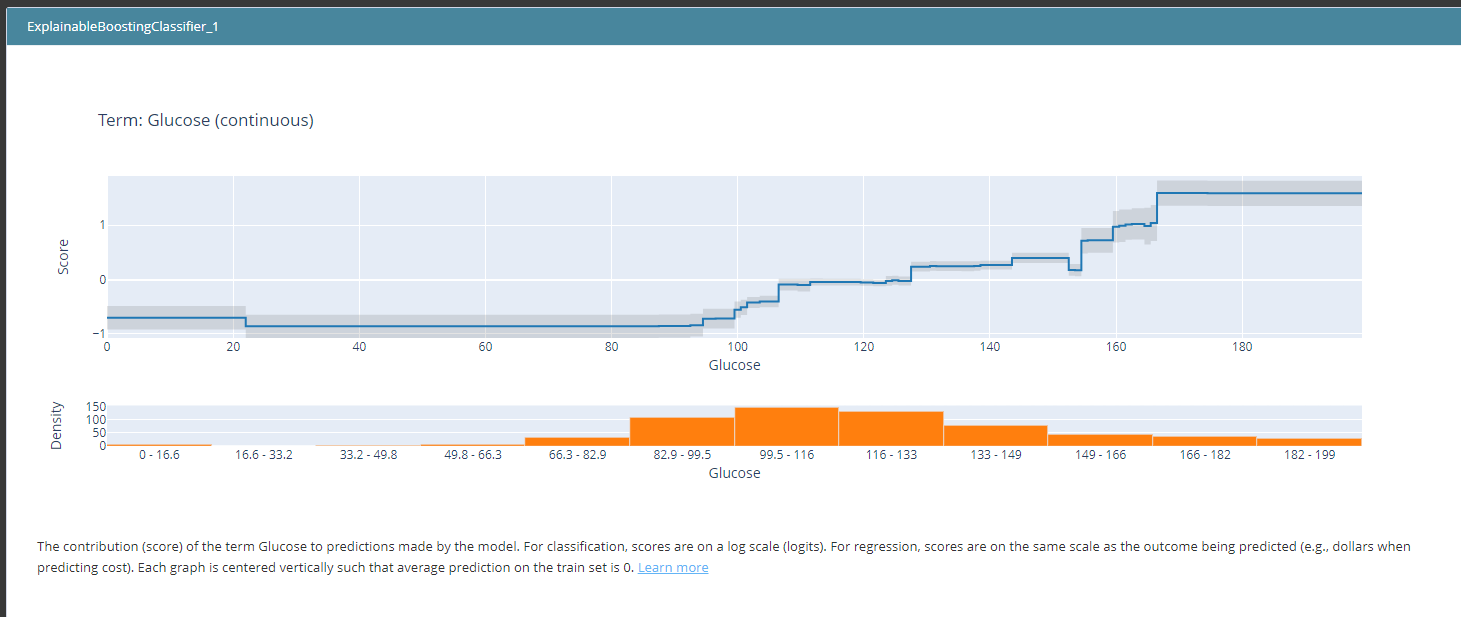

Wybierając konkretne cechy otrzymujemy dwa wykresy:

* pierwszy z nich mówi nam o tym jak zmiana wielkości parametru wpływa na klasyfikację (wykres szans),

* drugi wykres to rozkład wartości.

**Interpretacja:**

Według modelu szanse na to, że pacjentka jest chora na cukrzycę zaczynają wzrastać przy stężeniu glukozy na poziomie ok. 95 i od tego momentu wzrost stężenia glukozy zwiększa szanse klasyfikacji pacjentki jako chorej na cukrzycę. Stężenie glukozy na poziomie 160 i więcej oznacza, że model z dużym prawdopodobieństwem zaklasyfikuje pacjentkę jako chorą.

UWAGA:

Analizując wyniki trzeba mieć na uwadze jak rozkładają się wartości w zbiorze danych. Jeżeli jakaś grupa jest zbyt mała (niereprezentatywna) to może prowadzić to do błędów np. w zbiorze danych jest niewiele kobiet powyżej 60 roku życia, analizując wykres szans wydawałoby się, że kobiety powyżej 62 roku życia mają znacząco mniejsze szanse na zaklasyfikowanie jako chore na cukrzycę, co nie jest logiczne. Oznacza to, że modele wytrenowane na tym zbiorze danych będą uczyć się pewnej stronniczości co do wieku pacjentek, przez co będą mieć problem z generalizacją. Tego typu problemy pogarszają również jakość klasyfikacji.

**Zadanie:**

1) Jakie 4 cechy lub intereakcje cech są najbardziej istotne według modelu ?

2) Proszę otworzyć i zinterpretować wykres jednej wybranej cechy.  


In [45]:
ebm_global = ebm.explain_global()
show(ebm_global)

c:\Users\j.mazur\Documents\statystyka\.venv\Lib\site-packages\interpret\visual\_udash.py:117: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



<!-- http://127.0.0.1:7001/1445040068560/ -->

**ODP:**

Lokalne wyjaśnienia pokazują, w jaki sposób model dokonuje pojedynczej prognozy (można sprawdzić każdą pojedynczą prognozę). W przypadku modeli glassbox wyjaśnienia te są dokładne – doskonale opisują, w jaki sposób model podjął decyzję. Wyjaśnienia lokalne są przydatne do opisywania, które czynniki miały największy wpływ na prognozę.


In [46]:
ebm_local = ebm.explain_local(X_test, y_test)
show(ebm_local)

c:\Users\j.mazur\Documents\statystyka\.venv\Lib\site-packages\interpret\visual\_udash.py:117: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



<!-- http://127.0.0.1:7001/1445060392976/ -->

**Interpretacja:** 6: Actual(0), Predicted(0) - PrScore(0.984) model zaklasyfikuje pacjentkę o podanych cechach jako zdrową (w rzeczywistości również jest zdrowa), największy wpływ ma na to BMI, stężenie glukozy, wiek i stężenie insuliny.

UWAGA: w każdej z przedstawionych analiz cechy decydujące są różne (w ten sposób otrzymujemy różne kombinacje).

**Zadanie:**

Proszę zinterpretować poniższy wykres.

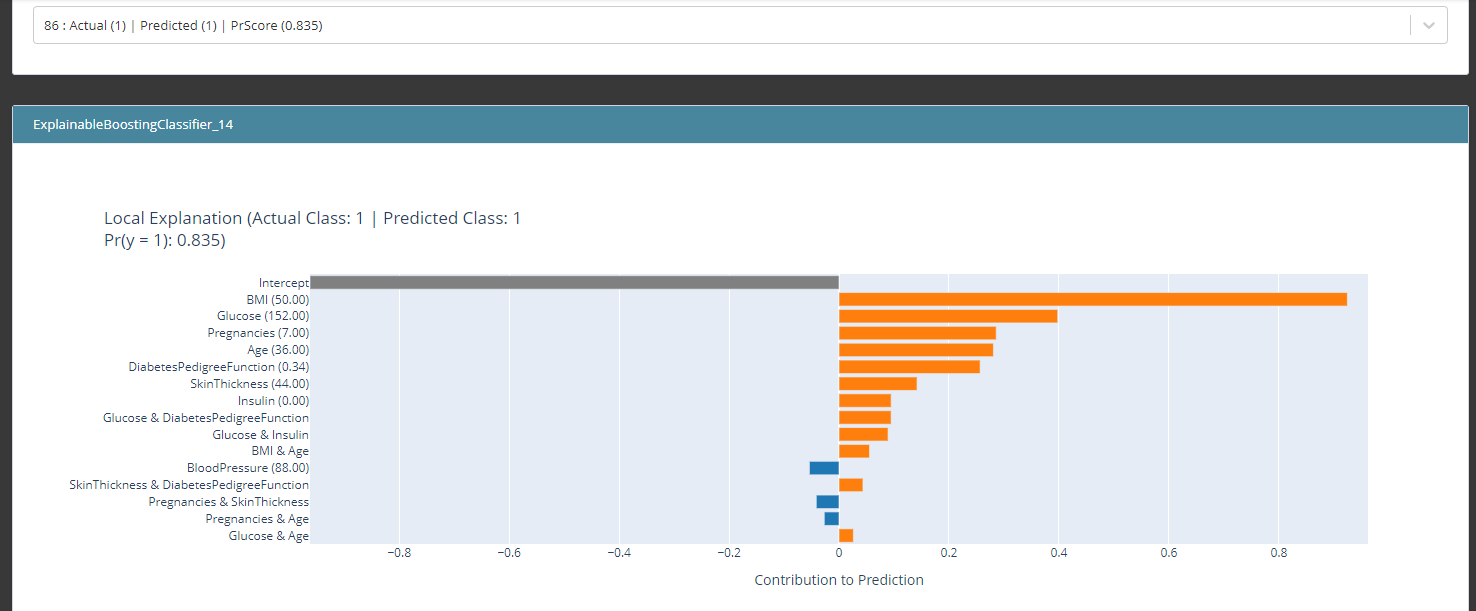

**ODP:**

Z przeprowadzonych analiz dowiedzieliśmy się, że wiek choć wydaję się być bardzo istotny dla modelu to może pogarszać jakość klasyfikacji, korzystając z analizowanego modelu lokalnego wiemy, że najistotniejszymi cechami w tym wypadku były: BMI, stężeni glukozy, liczba ciąż i wiek. W takim wypadku można spróbować wytrenować model na 3 cechach: liczbie ciąż, BMI oraz stężeniu glukozy. Nie uwzględniamy wieku, ponieważ cecha ta prowadzi do stronniczości modelu.

**Zadanie:**

Proszę wykorzystać do klasyfikacji 3 cechy: liczbę ciąż, BMI i stężenie glukozy. Następnie proszę dobrać najlepsze parametry estymatora z wykorzystaniem GridSearchCV.


Czy udało się poprawić jakość klasyfikacji pomimo uproszczenia modelu (redukcja z 4 do 3 cech)?


In [53]:
# Rozwiązanie
cechy = ['Glucose', 'BMI', 'Pregnancies']

X = df.drop(['Outcome'], axis = 1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X[cechy], y, test_size=0.2, random_state=42)

X_train.head()

,Glucose,BMI,Pregnancies
60,84,0.0,2
618,112,28.2,9
346,139,28.7,1
294,161,21.9,0
231,134,46.2,6


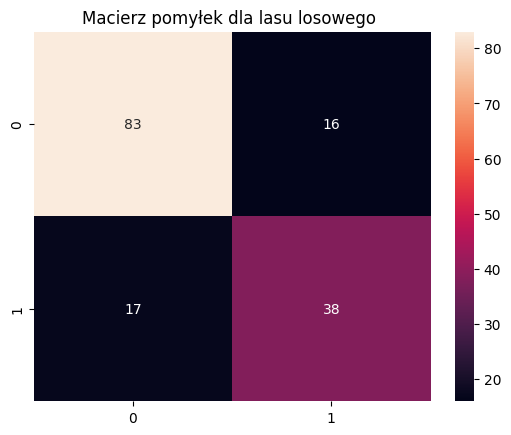

Raport klasyfikacji dla lasu losowego 
              precision    recall  f1-score   support

           0       0.83      0.84      0.83        99
           1       0.70      0.69      0.70        55

    accuracy                           0.79       154
   macro avg       0.77      0.76      0.77       154
weighted avg       0.78      0.79      0.79       154



In [54]:
# Standaryzacja cech
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Wytrenowanie klasyfikatora
rf_classifier_full = RandomForestClassifier(n_estimators= 50, criterion='log_loss', random_state=42)
rf_classifier_full.fit(X_train_scaled, y_train)

# Prognozy i metryki
rf_predictions_full = rf_classifier_full.predict(X_test_scaled)
rf_confusion_matrix_full = confusion_matrix(y_test, rf_predictions_full)
rf_classification_report_full = classification_report(y_test, rf_predictions_full)

# Wizualizacja macierzy pomyłek
sns.heatmap(rf_confusion_matrix_full, annot=True, fmt="d")
plt.title('Macierz pomyłek dla lasu losowego ')
plt.show()

# Wyświetlenie raportu klasyfikacji
print("Raport klasyfikacji dla lasu losowego ")
print(rf_classification_report_full)

**ODP:**